# Homework 03

In [ ]:
# load packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 1 Data Set

In [ ]:
def onehotify(tensor):
  vocab = {'A':'1','G':'3','C':'2','T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
  return onehot

In [ ]:
def convertData(data):
  # Splitting the dataset into sequence data and labels seperatly
  data_tensor = [point[0] for point in data]
  label_tensor = [point[1] for point in data]
  
  # Turning tensors into dataset so mapping can be applied
  dataset_seq = tf.data.Dataset.from_tensor_slices(data_tensor)
  dataset_label = tf.data.Dataset.from_tensor_slices(label_tensor)

  # mapping each element in the dataset to the value defined by the lambda function
  # onehot encoding each nucleotide in each genomic sequence of the dataset
  dataset_seq = dataset_seq.map(lambda seq : onehotify(seq))
  # onehot encoding the labels
  dataset_label = dataset_label.map(lambda lab : tf.one_hot(lab, 10))

  # zip together input and labels
  dataset_final = tf.data.Dataset.zip((dataset_seq, dataset_label))

  # setting buffer_size, batch_size and prefetch for the input pipeline
  dataset_final = dataset_final.shuffle(buffer_size=128)
  dataset_final = dataset_final.batch(128)
  dataset_final = dataset_final.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset_final

In [ ]:
# load train and test datasets
train_data = tfds.load(name = 'genomics_ood', split = 'train[:10%]', try_gcs = True, as_supervised = True)
test_data = tfds.load(name='genomics_ood', split = 'test[:10%]', try_gcs= True, as_supervised=True)

# send datasets through input pipeline
test_dataset_final = convertData(train_data)
train_dataset_final = convertData(test_data)

## 2 Model

In [ ]:
from tensorflow.keras.layers import Layer

class Model(Layer):

  def __init__(self):
    super(Model, self).__init__()
    # Hidden Layer 1: 256 units.  With sigmoid activation function.
    self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                            activation=tf.keras.activations.sigmoid
                                            )
    # Hidden layer 2:  256 units.  With sigmoid activation function.
    self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                            activation=tf.keras.activations.sigmoid
                                            )
    #Output:  10 units.  With softmax activation function.
    self.output_layer = tf.keras.layers.Dense(units=10,
                                            activation=tf.keras.activations.softmax
                                            )
        
  def call(self, x):
  # Define the forward step.
    x = self.hidden_layer_1(x)
    x = self.hidden_layer_2(x)
    x = self.output_layer(x)
    return x


## 3 Training

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy

In [ ]:
tf.keras.backend.clear_session()
import time

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin

test_loss, test_accuracy = test(model, test_dataset_final, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset_final, cross_entropy_loss)
train_losses.append(train_loss)

start = time.time()

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset_final = train_dataset_final.shuffle(buffer_size=128)
    test_dataset_final = test_dataset_final.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset_final:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset_final, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
  
print("Time: ", time.time()- start)

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9
Time:  255.76212096214294


In [ ]:
# Please ignore this function. It was created to benchmark the performance improvements of using prefetch
def benchmark(dataset, num_epochs=20):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(0.01)
    tf.print("Execution time:", time.perf_counter() - start_time)


benchmark(
    train_dataset_final.prefetch(tf.data.experimental.AUTOTUNE)
)
benchmark(
    train_dataset_final
)

Execution time: 60.666304115
Execution time: 61.04840030400004


## 4 Visualization

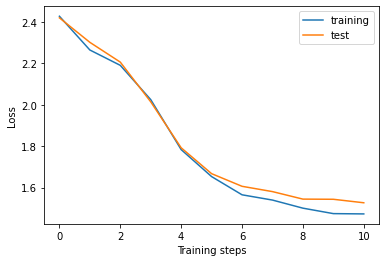

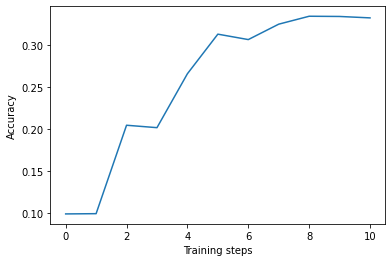

In [ ]:
# Visualize accuracy and loss for training and test data. 
# Plot training and test loss.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

# Plot test accuracy
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()